In [1]:
using LinearAlgebra
using Parameters
using SpecialFunctions
using Plots
using LaTeXStrings
include("tauchen.jl")
include("util.jl")

CRRA (generic function with 1 method)

In [2]:
@with_kw  struct params{TF<:Float64, TI<:Int64, TV<:AbstractVector{<:Real},
                        TM<:AbstractMatrix{<:Real}}

    # parameters
    β::TF = 0.96 # subjective discount factor
    μ::TI = 3 # risk aversion (=3 baseline)
    δ::TF = 0.08 # depreciation
    α::TF = 0.36 # capital share of income
    b::TI = 3 # borrowing limit

    # labor productivity
    s::TV # labor productivity grid
    prob::TM # transition matrix
    labor::TF # aggregate labor supply

    # iteration settings
    maxiter::TI = 2000
    tol::TF = 1e-5
end

params

In [3]:
mutable struct result{TF<:Float64, TM<:AbstractMatrix{<:Real}}
    
    
    K::TF # equilibrium capital
    eq_rate::TF
    kfun::TM # policy function
end

In [4]:
function main(;Nl::Int = 7, ρ= 0.6, σ= 0.4, M::Int = 2, indE::Int =[1,2,3,4])

    p = get_transition_matrix(Nl, ρ, σ, M)
    @unpack α, β, δ, labor = p
    
    
    if indE == 1 || indE== 2

        #============================================
         compute individual policy function and E(a)
        ============================================#
        
        # create rental rate grid
        NR = 20;
        minR = -0.03;
        maxR = (1.0-β)/β -0.001;
        R =  collect(LinRange(minR, maxR, NR))
        A = similar(R) #E(a)
        
        if indE == 1
            
            for (ind, R_val) in enumerate(R)
                A[ind], kfun = aiyagari_vfi1(p,R_val)
            end
            
        elseif indE == 2
            
            for (ind, R_val) in enumerate(R)
                A[ind], kfun = aiyagari_vfi2(p,R_val)
            end
            
        end
        
        R_K = collect(range(0, 0.05, step= 0.005))
        K   = labor*(α./(R_K .+ δ)).^(1/(1-α))
  
    elseif indE == 3
        #======================
        Compute K and r in EQ
        ======================#
        rate0 = 0.02 # initial guess (start with a value less than eq value)
        adj = 0.001
        
        ind = 0 
        
        for i in 1:p.maxiter
            K0 = labor*(α/(rate0+ δ))^(1/(1-α))
            K1, kfun = aiyagari_vfi2(p, rate0)
            
            if K0 < K1
                ind = 1
            end
            
            rate0 += adj
            global res = result(K1, rate0, kfun)
            if ind == 0
                # interest rate and capital in equilibrium
                eq_rate = rate0
                eq_K = K0           
                break
            end
        end
    
    elseif indE == 4
        
        #======================
         compute K and r in eq
        ======================#
        
        rate0 = 0.025
        errtol = 0.001
        maxiter = 200
        adj = 0.001
        
        for iter in 1:maxiter
            K0 = labor*(α/(rate0+δ))^(1/(1-α))
            K1, kfun = aiyagari_vfi2(p, rate0)
            
            
            err = abs(K1 - K0)
            
            rate0 += adj*(K0 - K1)
            global res = result(K0, rate0, kfun)
            if err < errtol
                
                # interest rate and capital in equilibrium
                eq_rate = rate0
                eq_K = K0
                break
            end
        end
        
    else 
        throw(ArgumentError("indE can be only 1~4"))
    end
    
    
    #==================================
     Plot
    ===================================#
    
    if indE == 1 || indE == 2
        
        plot(A, R, color = "red", linewidth = 2.0, linestyle = :dash, 
             shape = :star8, label="")
        plot!(K,R_K, color = "blue", linewidth = 2.0, label="")
        
        title!("Aiyagari 1994")
        xlabel!("E(a) and K")
        ylabel!("Interest rate")
        xlims!((0, 10))
        ylims!((-0.03, 0.05))
        
    elseif indE == 3 || indE == 4
        
        if res.eq_rate <= 0
            ϕ = p.b
        else
            #  write wage as a function of interest rate
            wage = (1-p.α)*((p.α/(res.eq_rate+p.δ))^p.α)^(1/(1-p.α))
            ϕ = min(p.b, wage*p.s[1]/res.eq_rate)
        end
        
       # capital grid (need define in each iteration since it depends on r/phi)
        Nk   = 150 # grid size for state 
        maxK = 20 # maximum value of capital grid
        minK = -ϕ # borrowing constraint
        gridk= collect(LinRange(minK, maxK, Nk))       # state of assets

        plot(gridk, res.kfun[1,:], color = "blue", linewidth = 2.0, 
             label= L"l_{low}", legend=:topleft)
        plot!(gridk, res.kfun[4,:], color = "red", linewidth = 2.0,
              linestyle = :dash, label=L"l_{mid}")
        plot!(gridk, res.kfun[7,:], color = "black", linewidth = 2.0,
              linestyle = :dashdot,  label= L"l_{high}")
        
        title!("Policy function")
        xlabel!("a")
        ylabel!(L"a' = g(a, l)")
        xlims!((-3, 10))
        ylims!((-3, 10))
        
    end
    
end

main (generic function with 1 method)

In [5]:
function get_transition_matrix(Nl::Int, ρ, σ, M::Int; ind::Int=0)

    logs, trans, invdist = tauchen(Nl, ρ, σ, M)
    s = exp.(logs)
    labor = dot(s, invdist)

    #labor in the baseline (used only in only in experiments)
    labor0 = 1.125709056856582

    # adjust productivity grid s.t. labor remains unchanged(in experiments)
    if ind==1
       adj=labor0/labor;
       s=s*adj;
       labor = dot(s, invdist)
    end

    return p = params(s = s, prob = trans, labor = labor)
end

get_transition_matrix (generic function with 1 method)

In [6]:
function aiyagari_vfi1(p::params, r)

    # computes aggregate savings given aggregate interest rate r

    #  write wage as a function of interest rate
    wage = (1-p.α)*((p.α/(r+p.δ))^p.α)^(1/(1-p.α))

    # borrowing limit
    if r<=0
        ϕ = p.b
    else
        # b is adhoc
        # the second term is natural limit
        ϕ = minimum([p.b, wage*p.s[1]/r])
    end

    # capital grid (need define in each iteration since it depends on r/phi)
    Nk   = 100                      # grid size for state and control
    maxK = 20                      # maximum value of capital grid
    minK = -ϕ                     # borrowing constraint

    gridk= collect(LinRange(minK, maxK, Nk))       # state of assets

    #  initialize some variables
    Nl = size(p.s)[1]
    v      = zeros(Nl,Nk)
    kfun   = similar(v)
    kfunG  = zeros(Int64, Nl, Nk)
    tv     = similar(v)
    kfunG_old=similar(v)


    for VFI_iter in 1:p.maxiter
        
        for (ind_l, val_l) in enumerate(p.s)
            for (ind_current, val_current) in enumerate(gridk)
                ind_future_max = Nk
                vtemp=-1000000*ones(Nk)

                for (ind_future, val_future) in enumerate(gridk)
                    cons = val_l*wage + (1+r)*val_current - val_future

                    if cons <= 0
                        ind_future_max = ind_future - 1
                        break
                    end
                    
                    vpr=0
                    for ind_l_future in 1:Nl
                        vpr += p.prob[ind_l,ind_l_future]*v[ind_l_future, ind_future]
                    end 
                    
                    util = CRRA(cons, p.μ)
                    vtemp[ind_future] = util + p.β * vpr
                    
                end

                t1,t2 = findmax(vtemp[1:ind_future_max])
                tv[ind_l,ind_current]   = t1
                kfunG[ind_l,ind_current]= t2
                kfun[ind_l,ind_current] = gridk[t2]
            end
        end


        err=maximum(maximum(abs.(kfunG-kfunG_old)))
        v=copy(tv)
        kfunG_old= copy(kfunG)
        
        if err == 0
            break
        end
    end

    #============= 
     distribution
    =============#
    mea0=ones(Nl,Nk)/(Nl*Nk)
    mea1=zeros(Nl,Nk)

    for iter in 1:p.maxiter
        
        for ind_current in 1:Nk
            for ind_l in 1:Nl
                ind_future = kfunG[ind_l, ind_current]
                
                for ind_l_future in 1:Nl
                    mea1[ind_l_future, ind_future] += p.prob[ind_l,ind_l_future]*mea0[ind_l,ind_current]
                end
            end
        end
        
        err = maximum(maximum(abs.(mea1 - mea0)))
        mea0 = copy(mea1)
        mea1 = zeros(Nl, Nk)
        
        if err <= p.tol
            break
        end
    end
    
    meank= sum(mea0.*kfun)
        

    return meank, kfun
end

aiyagari_vfi1 (generic function with 1 method)

In [7]:
function aiyagari_vfi2(p::params, r)

    # computes aggregate savings given aggregate interest rate r

    #  write wage as a function of interest rate
    wage = (1-p.α)*((p.α/(r+p.δ))^p.α)^(1/(1-p.α))

    # borrowing limit
    if r<=0
        ϕ = p.b
    else
        # b is adhoc
        # the second term is natural limit
        ϕ = minimum([p.b, wage*p.s[1]/r])
    end

    # capital grid (need define in each iteration since it depends on r/phi)
    Nk     = 150                      # grid size for state 
    maxK   = 20                      # maximum value of capital grid
    minK   = -ϕ                     # borrowing constraint
    Nk2    = 500                    # grid size for control
    
    gridk  = collect(LinRange(minK, maxK, Nk))       # state of assets 
    gridk2 = collect(LinRange(minK, maxK, Nk2)) 
    intk = gridk[2] - gridk[1] 
    
    #  initialize some variables
    Nl = size(p.s)[1]
    v      = zeros(Nl,Nk)
    kfun   = similar(v)
    kfunG  = zeros(Int64, Nl, Nk)
    tv     = similar(v)
    kfunG_old=similar(v)


    for VFI_iter in 1:p.maxiter
        
        for (ind_l, val_l) in enumerate(p.s)
            for (ind_current, val_current) in enumerate(gridk)
                
                ind_future_max = Nk2
                vtemp=-1000000*ones(Nk2) # initialization

                for (ind_future, val_future) in enumerate(gridk2) # control
                    
                    cons = val_l*wage + (1+r)*val_current - val_future

                    if cons <= 0
                        ind_future_max = ind_future - 1
                        break
                    end
 
                    if ind_future == Nk2
                        
                        ind_future1 = Nk
                        ind_future2 = Nk
                        pr1 = 1
                        pr2 = 0
                    else
                        temp = (ϕ + gridk2[ind_future])/intk
                        ind_future1 = Int(floor(temp) + 1)
                        ind_future2 = ind_future1 + 1
                        pr2 = (gridk2[ind_future] - gridk[ind_future1])/intk
                        pr1 = 1 - pr2
                    end
                    
                    vpr=0
                    for ind_l_future in 1:Nl
                        vpr += p.prob[ind_l,ind_l_future]*(pr1*v[ind_l_future, ind_future1] + pr2*v[ind_l_future, ind_future2])
                    end 
                    
                    util = CRRA(cons, p.μ)
                    vtemp[ind_future] = util + p.β * vpr
                    
                end

                t1,t2 = findmax(vtemp[1:ind_future_max])
                tv[ind_l,ind_current]   = t1
                kfunG[ind_l,ind_current]= t2
                kfun[ind_l,ind_current] = gridk2[t2]
            end
        end


        err=maximum(maximum(abs.(kfunG-kfunG_old)))
        v=copy(tv)
        kfunG_old= copy(kfunG)
        
        if err == 0
            break
        end
    end

    #============= 
     distribution
    =============#
    mea0=ones(Nl,Nk)/(Nl*Nk)
    mea1=zeros(Nl,Nk)

    for iter in 1:p.maxiter
        
        for ind_current in 1:Nk
            for ind_l in 1:Nl
                
                ind_future = kfunG[ind_l, ind_current]
                
                if ind_future == Nk2
                    ind_future1 = Nk 
                    ind_future2 = Nk 
                    pr1 = 1
                    pr2 = 0 
                else 
                    temp = (ϕ + gridk2[ind_future])/intk
                    ind_future1 = Int(floor(temp) + 1)
                    ind_future2 = ind_future1 + 1
                    pr2 = (gridk2[ind_future] - gridk[ind_future1])/intk
                    pr1 = 1 - pr2
                end
                    
                                
                
                for ind_l_future in 1:Nl
                    mea1[ind_l_future, ind_future1] += p.prob[ind_l,ind_l_future]*pr1*mea0[ind_l,ind_current]
                    mea1[ind_l_future, ind_future2] += p.prob[ind_l,ind_l_future]*pr2*mea0[ind_l,ind_current]
                end
            end
        end
        
        err = maximum(maximum(abs.(mea1 - mea0)))
        mea0 = copy(mea1)
        mea1 = zeros(Nl, Nk)
        
        if err <= p.tol
            break
        end
    end
    
    meank= sum(mea0.*kfun)
        

    return meank, kfun
end

aiyagari_vfi2 (generic function with 1 method)

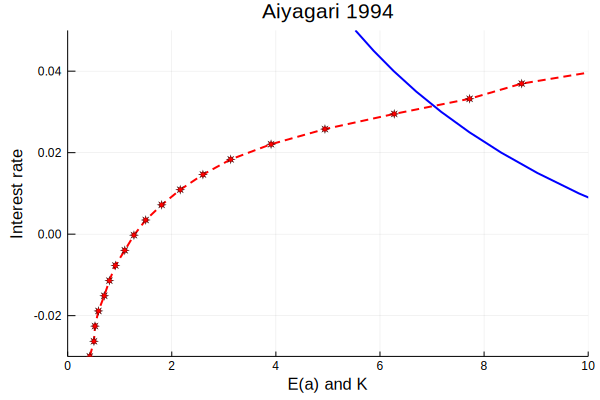

In [8]:
main(indE = 1)

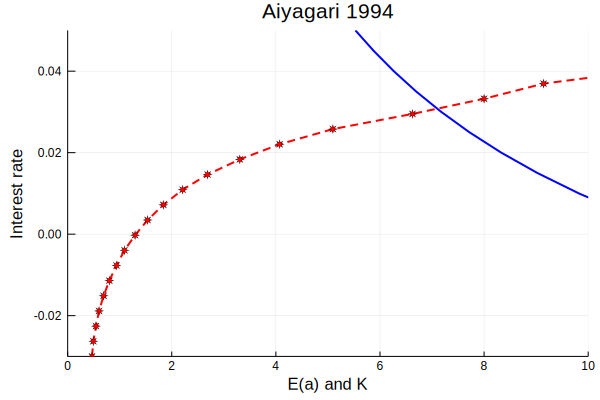

In [9]:
main(indE = 2)

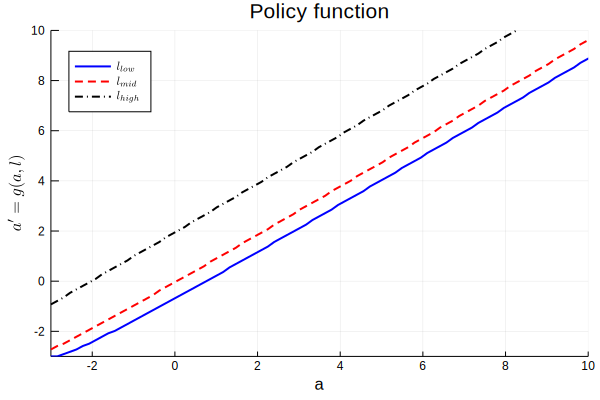

In [10]:
main(indE = 3)

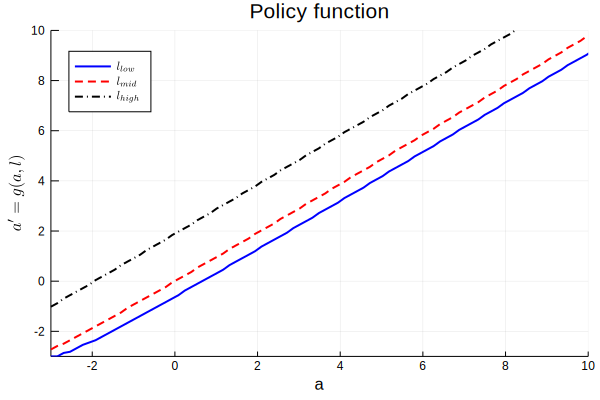

In [11]:
main(indE = 4)